In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc as pm

%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=300,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

project_dir = Path.cwd().parent
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

start_index = 100
M = 1
D = 10


In [3]:
Z_data = train_df.copy().values[start_index: start_index + M + D]
y_data = train_df.copy()[start_index: start_index + M + D].sum(axis=1)
y_data.index = pd.to_datetime(y_data.index)
mask = np.ones_like(Z_data, dtype=bool)

def mask_matrix(matrix):
        masked_matrix = matrix.copy()
        nrow, ncol = masked_matrix.shape

        for i in range(nrow):
            for j in range(ncol):
                if i + j > D - 1:
                     masked_matrix[i, j] = False
        return  masked_matrix

mask[-D:] = mask_matrix(np.array(mask[-D:]))


def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)



In [4]:
t = np.arange(0, len(Z_data))
# Ensures not forward looking
Z_data[~mask] = 0

Z_data

array([[252, 791, 617, 597, 363, 273,  62,  45, 209,  70],
       [410, 814, 646, 474, 377, 106,  70, 342, 163,  17],
       [374, 776, 503, 413,  93,  62, 344, 215,  16,   0],
       [354, 746, 497, 168, 100, 301, 234,  37,   0,   0],
       [353, 665, 210, 172, 452, 274,  72,   0,   0,   0],
       [385, 322, 222, 578, 342,  94,   0,   0,   0,   0],
       [173, 300, 526, 346, 114,   0,   0,   0,   0,   0],
       [217, 598, 455, 140,   0,   0,   0,   0,   0,   0],
       [358, 573, 191,   0,   0,   0,   0,   0,   0,   0],
       [282, 276,   0,   0,   0,   0,   0,   0,   0,   0],
       [210,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

GP Mean Function


In [ ]:

def proportion_net(Z_data, n_hidden=10, output_dim=D):
    # Prior
    W1_net = pm.Normal("W1_net", mu=0, sigma=1, shape=(D, n_hidden))
    b1_net = pm.Normal("b1_net", mu=0, sigma=1, shape=(n_hidden,))
    
    W2_net = pm.Normal("W2_net", mu=0, sigma=1, shape=(n_hidden, output_dim))
    b2_net = pm.Normal("b2_net", mu=0, sigma=1, shape=(output_dim,))
    
    # Forward pass
    h = pm.math.tanh(pm.math.dot(Z_data, W1_net) + b1_net)  # shape (T, n_hidden)
    p_raw = pm.math.dot(h, W2_net) + b2_net  # shape (T, D)
    
    return p_raw

with pm.Model() as model:
    t_shared = pm.Data("t", t)
    Z_shared = pm.Data("Z_data", Z_data)


    ell = pm.Gamma("ell", alpha=10, beta=10)   # length scale
    eta = pm.HalfNormal("eta", sigma=1)      # amplitude
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=t_shared[:, None])
    
    log_lam = f
    lam = pm.Deterministic("lam", pm.math.exp(log_lam))
    
    p_raw = proportion_net(Z_shared, n_hidden=10, output_dim=D)
    p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=1))

    # Create matrix of lam[t,:] * p[t,d]
    mu = lam[:, None] * p

    alpha = pm.HalfNormal("theta", sigma=2)  # overdispersion param
    # y_hat = pm.NegativeBinomial("y_hat", mu=lam, alpha=alpha)

    
    z = pm.NegativeBinomial("z", mu[mask], alpha, observed=Z_data[mask])

    idata = pm.sample(**sampler_kwargs())

    

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/pymc/model/fgraph.py:163: UserWarning: Detected variables likely created by GP objects. Further use of these old GP objects should be avoided as it may reintroduce variables from the old model. See issue: https://github.com/pymc-devs/pymc/issues/6883
  warnings.warn(
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x109e5f800>>
Traceback (most recent call last):
  File "/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/NowcastingVenv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Progress,Draws,Divergences,Step Size,Gradients/Draw
,209,0,0.00,1023
,251,0,0.00,1023


In [ ]:
with model:
    #in-sample 
    ppc = pm.sample_posterior_predictive(idata, extend_inferencedata=True, var_names=['z', 'lam', 'p'])
    


Sampling: [z]


Output()

In [ ]:
p_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["p"]
print(p_post_samples[-1, :, 0].values)

[6.50932052e-01 3.45891907e-02 2.46576144e-01 1.73348548e-04
 1.00205989e-02 4.53643014e-04 2.71209141e-04 5.67205205e-02
 2.59184483e-04 4.10796323e-06]


/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_57440/2389668266.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  p_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["p"]


/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_57440/380807233.py:2: FutureWarning: extract_dataset has been deprecated, please use extract
  lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["lam"]


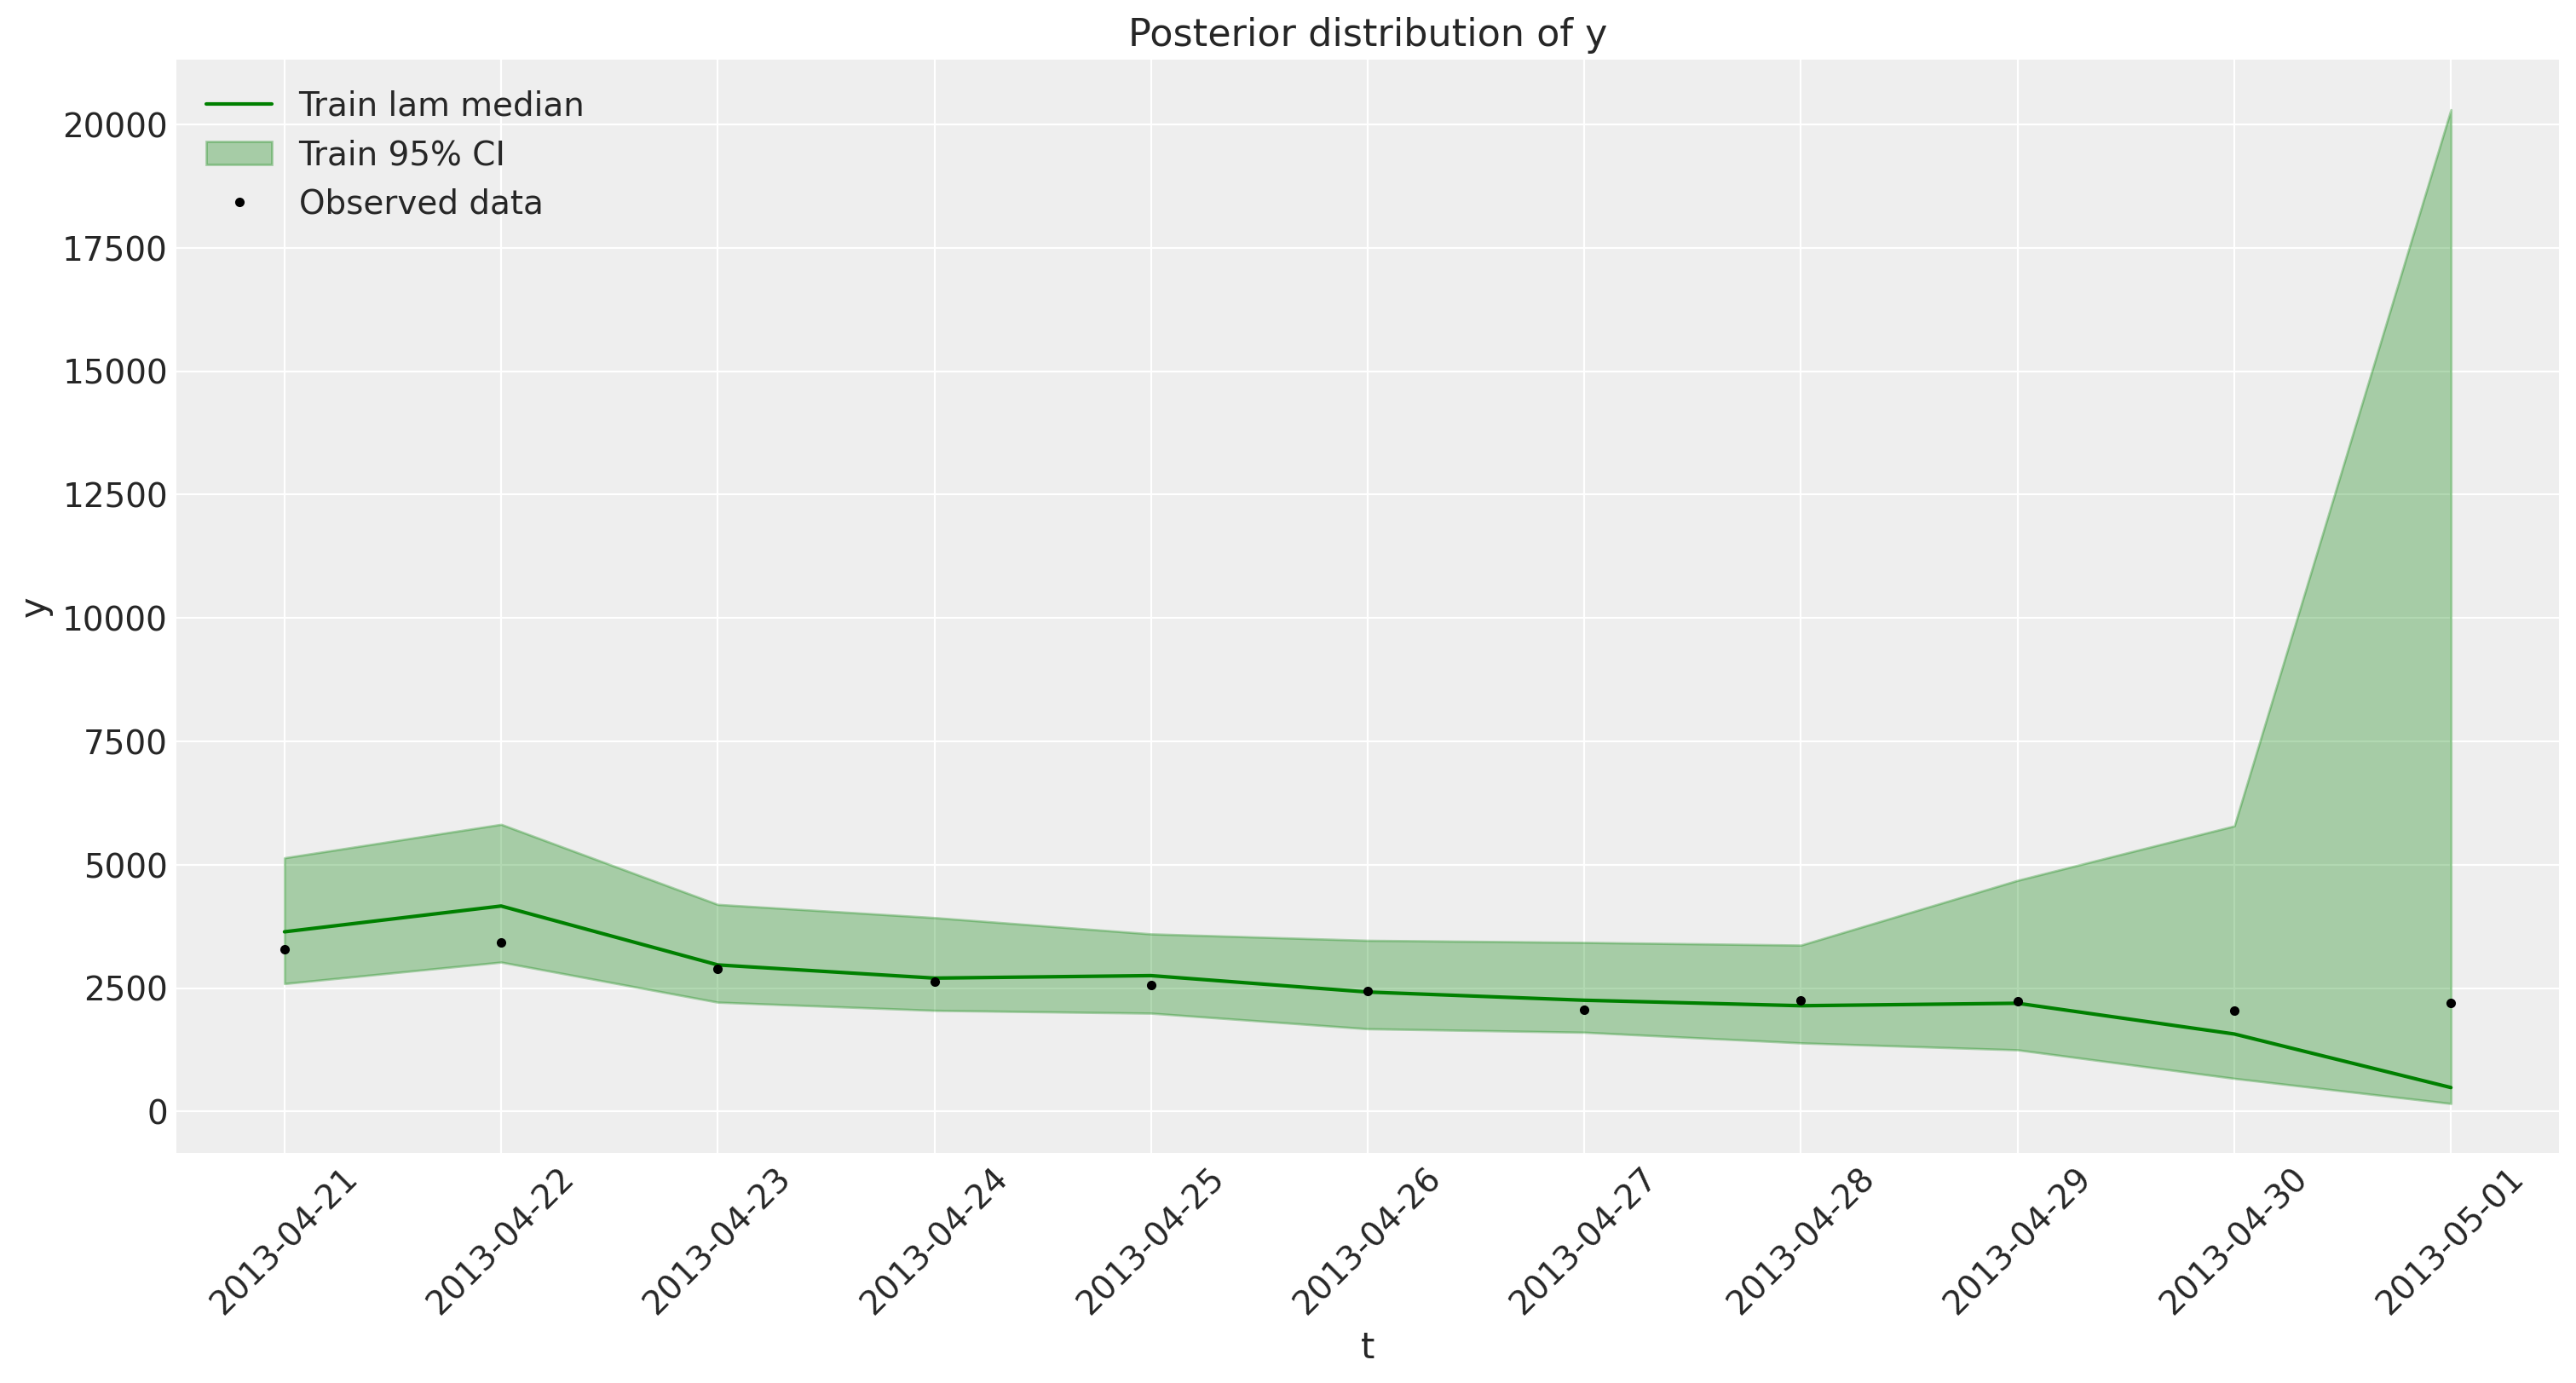

In [ ]:

# in sample
lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["lam"]
med_train = np.percentile(lam_post_samples, 50, axis=1)
lower_train = np.percentile(lam_post_samples, 2.5, axis=1)
upper_train = np.percentile(lam_post_samples, 97.5, axis=1)

# plot the results
fig = plt.figure(figsize=(15, 8))
ax = fig.gca()

# Plot CI for training data
ax.plot(y_data.index,  med_train, color='green', label="Train lam median")
ax.fill_between(y_data.index, lower_train, upper_train, color='green', alpha=0.3, label='Train 95% CI')



ax.plot(y_data.index, y_data, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("t")
plt.ylabel("y")
plt.xticks(rotation=45)
plt.title("Posterior distribution of y")
plt.legend()

TS mean func

In [ ]:
def proportion_net(Z_data, n_hidden=10, output_dim=D):
    # Prior
    W1_net = pm.Normal("W1_net", mu=0, sigma=1, shape=(D, n_hidden))
    b1_net = pm.Normal("b1_net", mu=0, sigma=1, shape=(n_hidden,))
    
    W2_net = pm.Normal("W2_net", mu=0, sigma=1, shape=(n_hidden, output_dim))
    b2_net = pm.Normal("b2_net", mu=0, sigma=1, shape=(output_dim,))
    
    # Forward pass
    h = pm.math.tanh(pm.math.dot(Z_data, W1_net) + b1_net)  # shape (T, n_hidden)
    p_raw = pm.math.dot(h, W2_net) + b2_net  # shape (T, D)
    
    return p_raw

with pm.Model() as model:
    t_shared = pm.Data("t", t)
    Z_shared = pm.Data("Z_data", Z_data)


    biweekly_fourier_shared = create_fourier_features(t_shared, n=20, p=14)
    weekly_fourier_shared = create_fourier_features(t_shared, n=10, p=14)


    # Trend
    b0 = pm.Normal("b0", mu=0, sigma=2)
    b1 = pm.Normal("b1", mu=0, sigma=2)
    trend = pm.Deterministic("trend", b0 + b1 * t_shared)
    
    # Fourier Seasonality
    beta_biweekly = pm.Normal("beta_biweekly", 0, 0.1, shape=biweekly_fourier_shared.shape[1])
    seasonality_biweekly = pm.Deterministic(
        "seasonality_biweekly", pm.math.dot(biweekly_fourier_shared, beta_biweekly)
    )

    beta_weekly = pm.Normal("beta_weekly", 0, 0.05, shape=weekly_fourier_shared.shape[1])
    seasonality_weekly = pm.Deterministic(
        "seasonality_weekly", pm.math.dot(weekly_fourier_shared, beta_weekly)
    )

    
    log_lam = trend + seasonality_biweekly #+ seasonality_weekly 
    lam = pm.Deterministic("lam", pm.math.exp(log_lam))

    
    p_raw = proportion_net(Z_shared, n_hidden=10, output_dim=D)
    p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=1))

    # Create matrix of lam[t,:] * p[t,d]
    mu = lam[:, None] * p

    alpha = pm.HalfNormal("alpha", sigma=2)  # overdispersion param
    # y_hat = pm.NegativeBinomial("y_hat", mu=lam, alpha=alpha)

    
    z = pm.NegativeBinomial("z", mu[mask], alpha, observed=Z_data[mask])

    idata = pm.sample(**sampler_kwargs())

    

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,32,0.00,1023
,1300,26,0.00,1023


In [10]:
with model:
    #in-sample 
    ppc = pm.sample_posterior_predictive(idata, extend_inferencedata=True, var_names=['z', 'lam', 'p'])
    


Sampling: [z]


Output()

In [11]:
p_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["p"]
print(p_post_samples[-1, :, 0].values)

[0.13135673 0.18964095 0.20608432 0.20234274 0.0839762  0.0731233
 0.01777602 0.04639    0.0346118  0.01469794]


/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_57822/2389668266.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  p_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["p"]


/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_57822/2735707202.py:5: FutureWarning: extract_dataset has been deprecated, please use extract
  lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["lam"]
/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_57822/2735707202.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


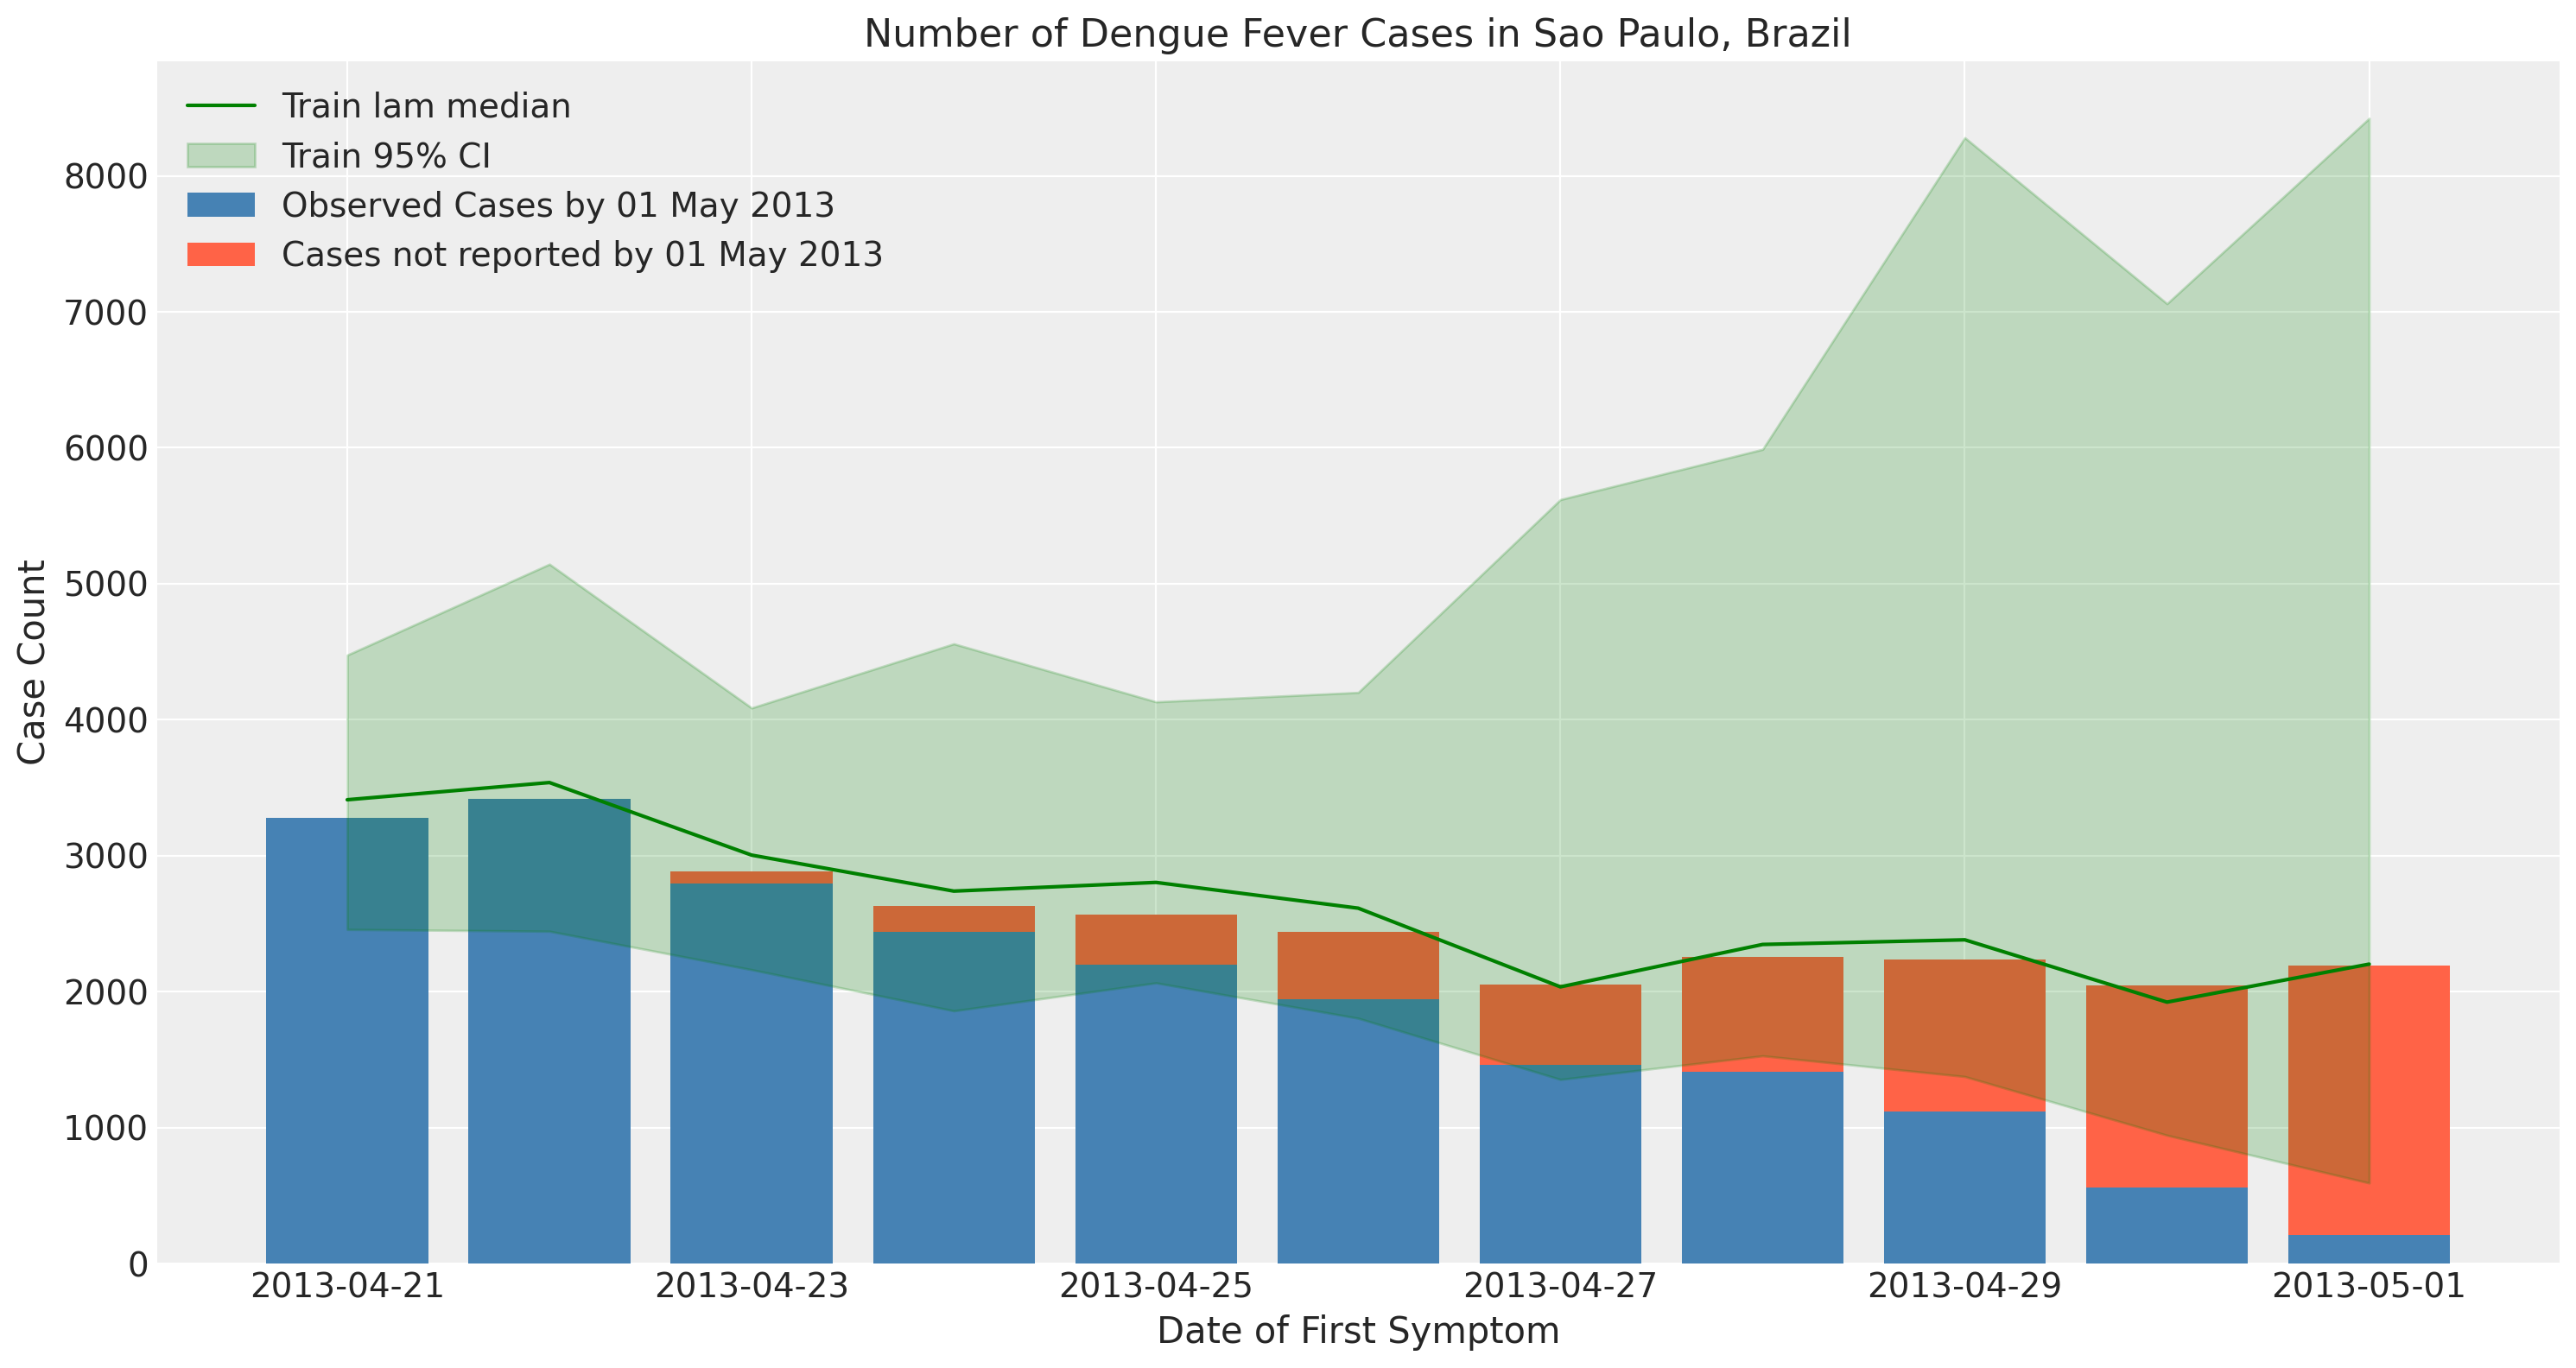

In [12]:
y_obs = Z_data.sum(1)
y_gap = y_data - y_obs

# in sample
lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=100)["lam"]
med_train = np.percentile(lam_post_samples, 50, axis=1)
lower_train = np.percentile(lam_post_samples, 2.5, axis=1)
upper_train = np.percentile(lam_post_samples, 97.5, axis=1)




# Plot stacked bars
plt.figure(figsize=(15, 8))

plt.bar(y_data.index, y_obs, color="steelblue", label=f"Observed Cases by {y_data.index[-1].strftime("%d %B %Y")}")
plt.bar(y_data.index, y_gap, bottom=y_obs, color="tomato", label=f"Cases not reported by {y_data.index[-1].strftime("%d %B %Y")}")

# Plot CI for training data
plt.plot(y_data.index,  med_train, color='green', label="Train lam median")
plt.fill_between(y_data.index, lower_train, upper_train, color='green', alpha=0.2, label='Train 95% CI')


plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.legend()
plt.tight_layout()
plt.show()